In [1]:
#기본설정

import numpy as np
import pandas as pd
from pandas import Series  # Series()를 사용하면 인덱스와 값을 동시에 확인할수있고 각각 뽑아낼수도있다.
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

# 플로틀리 : 과학 그래프 라이브러리 뿐만 아니라 개인 및 협업을 위한 온라인 그래프, 분석 및 통계 툴도 제공하고 있다고 합니다
# 플로틀리 오프라인을 사용하면 오프라인으로 그래프를 생성하고 로컬에 저장할수있습니다.
import plotly.offline as py
py.init_notebook_mode(connected=True) # 주피터노트북에서 오프라인으로 플로팅하기위해 실행해주어야함
import plotly.graph_objs as go 
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

# 3. Feature engineering
- 본격적인 feature engineering을 시작해보겠습니다.
- 가장먼저, dataset에 존재하는 null data를 채우려고 합니다.
- 아무 숫자로 채울수는 없고, null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
- null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기때문에, 신경써줘야할 부분입니다.
- Feature engineering은 실제 모델의 학습에 쓰려고 하는것이므로, train뿐만아니라 test도 똑같이 적용해주어야합니다. 잊지맙시다.

# 3.1 Fill Null
## 3.1.1 Fill Null in Age using title
- Age에는 null data가 177개나 있습니다. 이를 채울수있는 여러아이디어가 있을 것인데, 여기서 우리는 title + statistics를 사용해 보겠습니다.
- 영어에서는 Miss, Mrr, Mrs같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데 이를 사용해보겠습니다.
- pandas series에는 data를 string으로 바꿔주는 strmethod, 거기에 정규표현식을 적용하게해주는 extract method각 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다.

In [2]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') 
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')
# str.extract : 특정한 규칙을 가진 문자열을 검색하거나 치환하기위해서 사용
#  (' ([a-zA-Z]+).') : 띄어쓰기로 시작해 모든 알파벳이 포함된 문자열을 한 번이상 반복하다가 dot(.)으로 마무리하는 문자열이다.

- pandas 의 crosstab을 이용하여 우리가 추출한 Initial 과 Sex간의 Count를 살펴봅시다.

In [3]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위table을 참고하여, 남자, 여자가 쓰는 initial을 구분해 보겠습니다. replace메소드를 사용하면, 특정 데이터값을 원하는 값으로 치환해줍니다.

In [4]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)
# inplace=True를 해주면 원본데이터도 변경이된다.
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계있는 Miss,Mrs가 생존률이 높은 것을 볼 수 있습니다.ㅣ

<AxesSubplot:xlabel='Initial'>

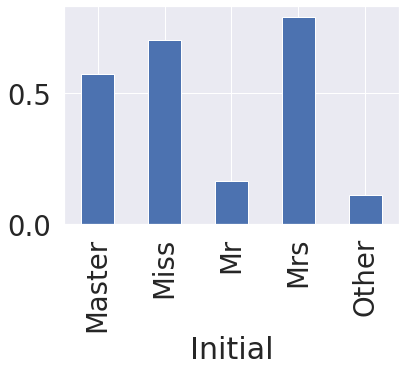

In [5]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 본격적으로 Null을 채울것입니다. null data를 채우는 방법은 정말 많이 존재합니다. statistics를 활용하는 방법도 있고, null data가없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.
- 여기서 statistics는 train data의 것을 의미합니다. 우리는 언제나 test를 unseen으로 둔 상태로 놔둬야하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 합니다.

In [6]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null value를 채우도록 하겠습니다.
- pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 참으로 편리합니다.
- 아래 코드 첫줄을 해석하자면, isnull()이면서 Initialdl Mr인 조건을 만족하는 row(탑승객)의 'Age'의 값을 33으로 치환한다 입니다. 
- loc + boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.


In [7]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

- 여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재합니다.
- 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보세요!

## 3.1.2 Fill Null in Embarked

In [8]:
print('Embarked has', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has 2  Null values


- Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠습니다.
- dataframe의 fillna method를 이용하면 쉽게 채울 수 있습니다. 여기 inplace=True로 하면 df_train에 fillna를 실제로 적용하게 됩니다.

In [9]:
df_train['Embarked'].fillna('S', inplace=True)

# 3.2 Change Age(continuous to categorical)
- Age는 현재 continuous feature입니다. 이대로 써도 모델을 세울수있지만, Age를 몇개의 group으로 나누어 category화 시켜줄수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.
- 방법이 여러가지있습니다. dataframe의 indexing방법인 loc를 사용하여 직접해줄수 있고, 아니면 apply를 사용해 함수를 넣어줄수있습니다. 
- 첫번째로 loc를 사용한 방법입니다. loc는 자주쓰게 되므로 그 사용법을 숙지하시면 좋습니다.
- 나이는 10살 간격으로 나누겠습니다.

In [10]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

- 두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.
- 훨씬 수월합니다. 

In [11]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

- 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
- 이를 확인하기 위해 Series 간 boolean 비교후 all()메소드를 사용합시다. all()메소드는 모든 값이 True면 True, 하나라도 False가 있으면 False를 줍니다.

In [12]:
print('1번 방법, 2번방법 둘다 같은 결과를 내면 True줘야함 ->', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번방법 둘다 같은 결과를 내면 True줘야함 -> True


- 보시다시피 True입니다. 둘 중 편한걸 선택하시면 됩니다.
- 이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거하겠습니다.

In [13]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

# 3.3 Change Initial,Embarked and Sex (string to numerical)
- 현재 Initial은 Mr, Mrs, Miss, Master, other 총5개로 이루어져있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야합니다.
- map method를 가지고 간단히 할 수 있습니다.
- 사전 순서대로 정리하여 mapping하겠습니다.

In [14]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

- Embarked 도 C, Q, S로 이루어져 있습니다. map을 이용해 바꿔봅시다.
- 그러기 앞서서, 특정 column에 어떤 값들이 있는지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts()를 써서 count까지 보는 방법이 있습니다.

In [15]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [16]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

- 위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다

In [17]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

- 한번 Null이 사라졌는지 확인해봅시다. Embarked Column만 가져온것은 하나의 panda의 Series객체므로, isnull()메소드를 사용해 Series의 값들이 null인지 아닌지에 대한 boolean값을 얻을 수 있습니다. 그리고 이것에 any()를 사용하여, True가 단하나라도 있을시(Null이 한개라도 있을 시) True를 반환해주게 됩니다. 우리는 Null을 S로 다 바꿔주었으므로 False를 얻게 됩니다.

In [18]:
df_train['Embarked'].isnull().any()

False

- Sex도 Female, male로 이루어져있습니다. map을 이용해 바꿔봅시다.

In [19]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

- 여지껏 고생하셨습니다. 이제 각 feature간의 상관관계를 한번 보려고 합니다. 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.

$$r_{xy} = \frac{Cov(x,y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^n(x_{i}-\bar x)(y_{i}-\bar y)}{S_{x}S_{y}}$$

- 우리는 여러 feature를 가지고 있으니 이를 하나의 maxtrix형태로 보면 편할텐데, 이를 heatmap plot이라고하며, dataframe의 corr()메소드와 seaborn을 가지고 편하게 그릴 수 있습니다.

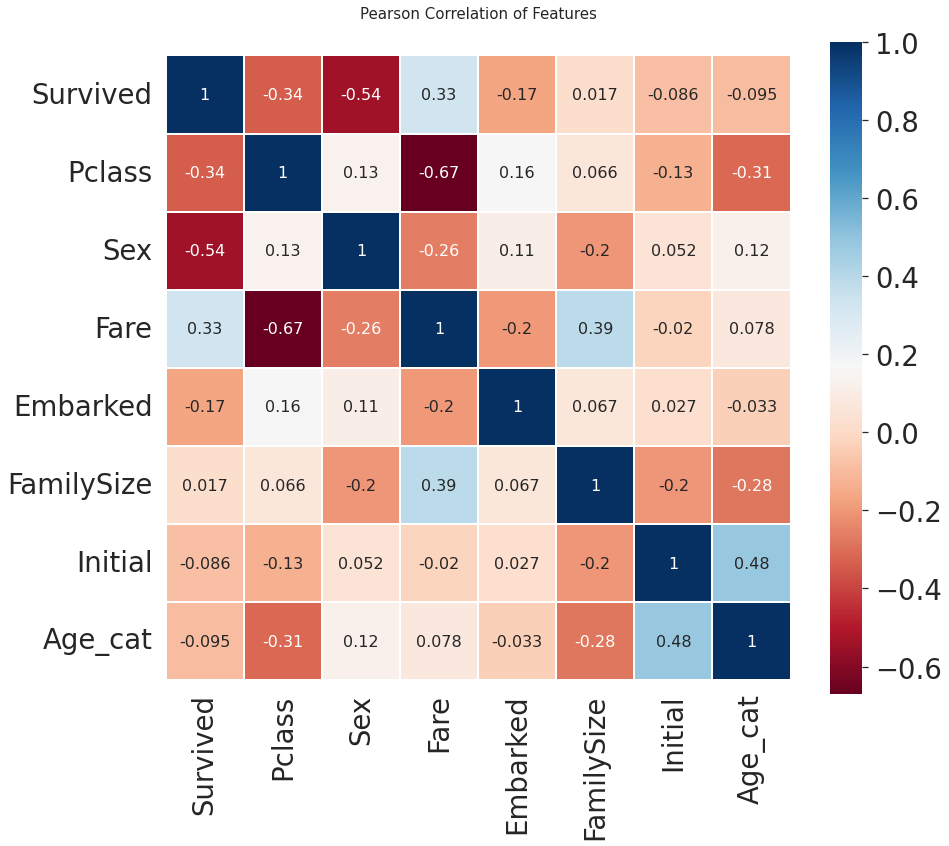

In [20]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})
# .corr():상관관계 계산, linewidths : 칸사이 간격,  vmax : 최대값  , annot : 숫자표시여부,  annot_kws : 숫자 크기  
del heatmap_data

- 우리가 EDA에서 살펴봤듯이, Sex와 Pclass가 Survived에 상관관계가 어느 정도 있음을 볼 수 있습니다.
- 생각보다 fare와 Embarked도 상관관계가 있음을 볼 수 있습니다.
- 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
- 이것은 우리가 모델을 학습시킬때, 불필요한(redundant, superfluous) feature가 없다는것을 의미합니다. 1 또는 -1의 상관관계를 가진 feature A,B가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 꺼니까요.
- 이제 실제로 모델을 학습시키기 앞서서 data preprocessing(전처리)을 진행해보겠습니다. 거의 다 와갑니다 힘냅시다!

# 3.4 One-hot encoding on Initial and Embarked
- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는것을 말합니다.
- one-hot encoding은 위 카테고리를 아래와 같이 (0,1)로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.
- 위와 같은 작업을 직접 코딩할 수도 있지만, pandas의 get_dummies를 사용하여 쉽게 해결 할 수 있습니다.
- 총 5개의 카테고리니, one-hot encoding을 하고나면 새로운 5개의 column이 생겨납니다.
- Initial을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [21]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')
df_train.head()
# columns : 특정열만 인코딩 

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


- 보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoding columnsrk 생성된 것이 보입니다. 
- Embarked에도 적용하겠습니다. Initial때와 마찬가지로 one-hot encoding을 사용해 표현하겠습니다.

In [22]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- 아주 쉽게 one-hot encoding을 적용했습니다.
- sklearn로 Labelencodr + OneHotencoder 이용해도 one-hot encoding이 가능합니다.
- 다른 튜토리얼에서 한번 써보겠습니다. 여기서는 get_dummies로 충분히 가능하기 때문에 get_dummies만으로 끝내겠습니다.
- 가끔 category가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

# 3.5 Drop columns
- 고생하셨습닏다. 이제 책상을 치울때입니다. 필요한 columns만 남기고 다 지웁시다.

In [23]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [24]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


- 보시다시피, train의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns를 가진 걸 확인할 수 있습니다.

# 4. Building machine learning model and prediction using the trained model
- 이제 준비가 다 되었으니 sklearn을 사용해 본격적으로 머신러닝 모델을 만들어 봅시다.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

- sklearn은 머신러닝의 처음부터 끝까지가 다 있습니다. feature engineering, preprocessing, 지도학습알고리즘, 비지도학습알고리즘, 모델평가, 파이프라인등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야합니다.
- 파이썬 라이브러리를 활용한 머신러닝책을 사서 공부하시길 매우 추천해드립니다.
- 지금 타이타닉 문제는 target class(survived)가 있으며,target class는 0,1로 이루어져 있으므로 binary classfication문제입니다.
- 우리가 지금 가지고 있는 train set의 survived를 제외한 input을 가지고  모델을 최적화시켜서 각 샘플의 생존유무를 판단하는 모델을 만들어 냅니다.
- 그후 모델이 학습하지 않았던 test set을 input으로 주어서 test set의 각 샘플의 생존 유무를 예측해봅니다.

# 4.1 Preparation - split, dataset into train, valid, test set
- 가장먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop을 사용해 간단히 할 수 있습니다.

In [26]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

- 보통 train, test만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.
- 마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)로 나가는 것이아니라, 팀훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.
- train_test_split을 사용하여 쉽게 train셋을 분리할 수 있습니다.

In [27]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- sklearn에서는 여러 머신러닝 알고리즘을 지원해줍니다.열거하기엔 너무 많으므로, 직접 documentation에 들어가 보시길 추천합니다.
- 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.
- 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다. 더 구체적인 모델 설명은 여러 블로그들 참고하시면 될 것이고, 저도 한번 추후 다뤄보겠습니다.
- 각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트분류기도 n_estimators, max_features,max_depth, min_samples_split, min_samples_leaf등 여러 파라미터들이 존재합니다.이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.
- 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해등이 필요합니다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이죠. 그래서 캐글을 추천합니다. 여러 데이터셋을 가지고 모델을 이리저리 써봐야 튜닝하는 감이 생길테니까요!
- 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로하고, 기본 default세팅으로 진행하겠습니다.
- 모델객체를 만들고, fit메소드로 학습시킵니다.
- 그런후 valid set input을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻습니다.

# 4.2 Model generation and prediction

In [28]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

- 단 세줄만으로 여러분은 모델을 세우고, 예측까지 해봤습니다.
- 자, 이제 모델의 성능을 한번 살펴보겠습니다.

In [29]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.09% 정확도로 생존을 맞춤


- 아무런 파라미터 튜닝도 하지 않았는데 82%의 정확도가 나왔습니다. 고생하셨습니다!

# 4.3 Feature importance
- 학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있습니다.
- 쉽게말해, 10=4*1 + 2*2 + 1*3을 생각하면, 우리는 *1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있습니다. feature importance는 4, 2, 1을 야기하며, *1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다.
- 학습된 모델은 기본적으로 featureimportances를 가지고 있어서 쉽게 그 수치를 얻을 수있습니다.
- pandas series를 이용하면 쉽게 sorting을 하여 그래프를 그릴 수 있습니다.

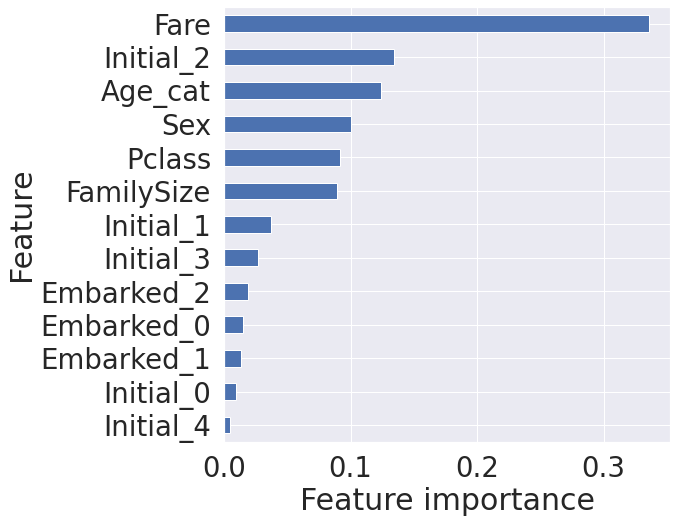

In [30]:
from pandas import Series
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며, 그뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다.
- 사실 feature importances는 지금 모델에서의 importance를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance가 다르게 나올 수 있습니다.
- 이 feature importance를 보고 실제로 Fare가 중요한 feature일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.
- feature importance를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature제거를 할 수 있습니다.

# 4.4 Prediction on Test set
- 이제 모델이 학습하지 않았던 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.
- 이 결과는 실제로 submission(제출용)이므로 결과는 leaderboard에서 확인 할 수 있습니다.
- 캐글에서 준 파일, gender_submission.csv파일을 읽어서 제출 준비를 하겠습니다.

In [31]:
submission = pd.read_csv('../input/titanic/gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


- 이제 testset에 대하여 예측을 하고, 결과를 csv파일로 저장해보겠습니다.

In [32]:
prediction = model.predict(X_test)
submission['Survived'] = prediction
submission.to_csv('./my_first_submission.csv', index=False)

- 이제 캐글에 제출해보도록 합시다.

# 5 Conclusion
- 정말 수고하셨습니다. 여러분은 titanic dataset을 가지고 data science를 경험해보셨습니다.
- 이걸로 끝이 아닙니다. 앞으로 배울것이 너무나 무궁무진합니다.
- 좀 더 참신한 feature engineering, 머신러닝모델 hyperparameter tunning, ensembling등, 무궁무진합니다...
- 꾸준히 커널 공부를 하시면 실력이 꾸준히 늘겁니다.
- 포기하지마시고 재밌게 하시면됩니다.
- 본 튜토리얼을 따라해주셔서 감사하며, 제유튜브 채널에 강의도 올려놨으니 한번 보시면 됩니다.